<h1><b></v>A practitioner's guide to Triton</b></h1>

By UmerHA (https://x.com/UmerHAdil // https://github.com/UmerHA/), for the cuda-mode group ❤️ May our brrrr level reach over 9000.

# Why & when to use Triton

**What is Triton**

In short: Triton is a language to program GPUs more conventiently. You write Python-ish code, which is then compiled into ptx code (the same thing cuda code is compiled into).

During the compilation, the Triton compiler tries to use clever tricks to rearrange the parts of your program (without changing the program's meaning!) to make it run faster. 

**Triton vs Cuda**

<img src='images/1_cuda_v_triton.png'>

source: https://zhuanlan.zhihu.com/p/672086654

CUDA is a high-end tool with many settings for the pros.
- full control over everything, so absolute max performance possible
- harder to get decent performance
- way more tedious to write and debug
- more complicated, so harder to learn


Triton is a  very good tool for most users
- you can't control everything, as some things are left to automatic optimization; so you probably won't get absolute max performance
- way easier to get good performance
- way easier to write and debug
- easier to learn, as it has a Python-like syntax

**Triton vs torch.compile**

`torch.compile` makes your model faster by trying to use existing kernels more effectively and creating simple new kernels. This may make your model fast enough. If not, you can decide to invest time to write faster Triton kernels.

(These simple new kernels that `torch.compile` creates are actually Triton kernels. So they are a good starting point for your custom kernels. See [Mark Saroufim](https://twitter.com/marksaroufim)'s [lecture 1 of cuda mode](https://www.youtube.com/watch?v=LuhJEEJQgUM&t=2200s) for how.)

**When to use Triton**

You start with your AI model.
1. If it's not fast enough, `torch.compile` it.
2. If it's not fast enough, check if you can rewrite your code to make it more suitable for `torch.compile`.
3. If it's not fast enough, check which parts are slow and write custom Triton kernel(s) for those.
4. If it's not fast enough, check which parts are slow and write custom CUDA kernel(s) for those.

(In the unlikely case you know beforehand tyou need absolute max performance, you can decide to directly start with CUDA.) 

**A note on rough edges**

As Triton is a newer project, people have found it to have a few rough edges. I have noted all rough edges I encountered with the comment "Weirdness: <description of what's weird to me>".

I expect it to get a lot more polished over time.

# How to write Triton kernels

Unlike with CUDA, we can debug Triton kernels just like any CPU program, if we set the environment variable `TRITON_INTERPRET = 1`. Then Triton runs on the CPU but simulates that it runs on the GPU.

I recommend writing all programs in the simulator first, and checking for correctness. If correct, then you can make it fast.

Below are some utility functions for debugging:
- `check_tensors_gpu_ready`: (i) assert all tensors are contiguous in memory and (ii) only if not simulating, assert all tensors are on gpu
- `breakpoint_if`: set a breakpoint, depending on conditions on pids
- `print_if` print sth, depending on conditions on pids

In [1]:
import os
from IPython.core.debugger import set_trace

os.environ['TRITON_INTERPRET'] = '1' # needs to be set *before* triton is imported

def check_tensors_gpu_ready(*tensors):
    for t in tensors:
        assert t.is_contiguous, "A tensor is not contiguous"
        if not os.environ.get('TRITON_INTERPRET') == '1': assert t.is_cuda, "A tensor is not on cuda"

def test_pid_conds(conds, pid_0=[0], pid_1=[0], pid_2=[0]):
    '''Test if condition on pids are fulfilled
    E.g.:
        '=0'  checks that pid_0 == 0
        ',>1' checks that pid_1 > 1
        '>1,=0' checks that pid_0 > 1 and pid_1 == 0
    '''
    pids = pid_0[0], pid_1[0], pid_2[0]
    conds = conds.replace(' ','').split(',')
    for i, (cond, pid) in enumerate(zip(conds, pids)):
        if cond=='': continue
        op, threshold = cond[0], int(cond[1:])
        if op not in ['<','>','>=','<=','=', '!=']: raise ValueError(f"Rules may only use these ops: '<','>','>=','<=','=', '!='. Invalid rule: '{condition}'.")
        op = '==' if op == '=' else op
        if not eval(f'{pid} {op} {threshold}'): return False
    return True

assert test_pid_conds('')
assert test_pid_conds('>0', [1], [1])
assert not test_pid_conds('>0', [0], [1])
assert test_pid_conds('=0,=1', [0], [1], [0])

def breakpoint_if(conds, pid_0=[0], pid_1=[0], pid_2=[0]):
    '''Stop kernel, if any condition of pids is fulfilled'''
    if test_pid_conds(conds, pid_0, pid_1, pid_2): set_trace()

def print_if(txt, conds, pid_0=[0], pid_1=[0], pid_2=[0]):
    '''Print txt, if any condition of pids is fulfilled'''
    if test_pid_conds(conds, pid_0, pid_1, pid_2): print(txt)

def cdiv(a,b): return (a + b - 1) // b
assert cdiv(10,2)==5
assert cdiv(10,3)==4

In [2]:
import torch
import triton
import triton.language as tl

# Programming model

With CUDA, we decompose the computation in 2 levels: First into blocks, then each block further into threads. All threads in a block run on the same SM and share the same Shared Memory. And each thread computes on **scalars**.

In Triton, we decompose the computation only in 1 level: Into blocks. There is no further decomposition into threads. **Triton requires us to perform operations on vectors**. Also, we don't need to and are not able to manage the shared memory. Triton does that automatically.

Example:

Let's say we want to add `x` and `y`, which are vectors of size 8, and save the output into `z` (also size 8). Let's use blocks of size 4, so we have `8 / 4 = 2` blocks.
- Cuda runs 2 blocks, each with 4 threads. Each of the 8 threads computes a single position, e.g. `z[0] = x[0] + y[0]`
- Triton also runs 2 blocks, which each performs vectorized addition. The vector size is the block size, which is 4. E.g. `z[0:3] = x[0:3] + y[0:3]`


**All** operations in triton kernels are vectorized: Loading data, operating on data, storing data, and creating masks.

Let's think about another simple example:

Again, we want to add `x` and `y`, which are now vectors of size **6**, and save the output into `z` (also size 6). Let's use blocks of size 4, so we have `cdiv(6, 4) = 2` blocks.

In [3]:
x = torch.tensor([1,2,3,4,5,6])
y = torch.tensor([0,1,0,1,0,1])

x, y, x+y

(tensor([1, 2, 3, 4, 5, 6]),
 tensor([0, 1, 0, 1, 0, 1]),
 tensor([1, 3, 3, 5, 5, 7]))

The cuda kernel would be the C-equivalent of this:

In [4]:
# x,y = input tensors, z = output tensors, n = size of x, bs = block size
def add_cuda_k(x, y, z, n, bs):
    # locate which part of the overall computation this specific kernel is doing
    block_id = ... # in our example: one of [0,1] 
    thread_id = ... # in our example: one of [0,1,2,3] 

    # identify the location of the data this specific kernel needs
    offs = block_id * bs + thread_id
    
    # guard clause, to make sure we're not going out of bounds
    if offs < n:

        # read data
        x_value = x[offs]
        y_value = y[offs]
        
        # do operation
        z_value = x_value + y_value
        
        # write data
        z[offs] = z_value

    # Important: offs, x_value, y_value, x_value are all scalars!
    # The guard condition kind of is also a scalar, as it check one condition on one value.

For illustration, here are the variables for every kernel:

<img src='images/2_cuda_variables.png'>

Let's now look at the corresponding triton kernel, which roughly looks like this:

In [5]:
# Note: this is for illustration, and not quite syntactically correct. See further below for correct triton syntax

def add_triton_k(x, y, z, n, bs):
    # locate which part of the overall computation this specific kernel is doing
    block_id = tl.program_id(0)  # in our example: one of [0,1] 
    
    # identify the location of the data this specific kernel needs
    offs = block_id * bs + tl.arange(0, bs) # <- this is a vector!
    
    # the guard clause becomes a mask, which is a vector of bools
    mask = offs < n # <- this is a vector of bools!
    
    # read data
    x_values = x[offs] # <- a vector is read!
    y_values = y[offs] # <- a vector is read!
    
    # do operation
    z_value = x_value + y_value  # <- vectors are added!
    
    # write data
    z[offs] = z_value  # <- a vector is written!

Again, for illustration, here are the variables for every kernel:

<img src='images/3_triton_variables.png'>

Note on jargon: In triton lingo, each kernel (which processes a block) is called a "program". I.e., our example above runs 2 programs. Therefore, "block_id" is often called "pid" (short for "program id"), but it's the same.

# Example 1: Copying a tensor

Let's looks at some examples. To keeps things simple, we'll use very small block sizes.

Goal: Given a tensor `x` of shape (n), copy it into another tensor `z`.

In [6]:
# # This is a normal python function, which launches the triton kernels
def copy(x, bs, kernel_fn):
    z = torch.zeros_like(x)
    check_tensors_gpu_ready(x, z)
    n = x.numel()
    n_blocks = cdiv(n, bs)
    grid = (n_blocks,)  # how many blocks do we have? can be 1d/2d/3d-tuple or function returning 1d/2d/3d-tuple

    # launch grid!
    # - kernel_fn is the triton kernel, which we write below
    # - grid is the grid we constructed above
    # - x,z,n,bs are paramters that are passed into each kernel function
    kernel_fn[grid](x,z,n,bs)

    return z    

**Note:** For educational purposes, the kernel below has a logic bug (but the syntax is correct). Can you spot it?

In [7]:
# # This is the triton kernel:

# The triton.jit decorator takes a python function and turns it into a triton kernel, which is run on the GPU.
# Inside this function only a subset of all python ops are allowed.
# E.g., when NOT simulating, we can't print or use breakpoints, as these don't exist on the GPU. 
@triton.jit
# When we pass torch tensors, they are automatically converted into a pointer to their first value
# E.g., above we passed x, but here we receive x_ptr
def copy_k(x_ptr, z_ptr, n, bs: tl.constexpr):
    pid = tl.program_id(0)
    offs = tl.arange(0, bs)  # compute the offsets from the pid 
    mask = offs < n
    x = tl.load(x_ptr + offs, mask) # load a vector of values, think of `x_ptr + offs` as `x_ptr[offs]`
    tl.store(z_ptr + offs, x, mask) # store a vector of values

    print_if(f'pid = {pid} | offs = {offs}, mask = {mask}, x = {x}', '')

    # Question: What is wrong with this kernel?

In [8]:
z = copy(x, bs=2, kernel_fn=copy_k)

pid = [0] | offs = [0 1], mask = [ True  True], x = [1 2]
pid = [1] | offs = [0 1], mask = [ True  True], x = [1 2]
pid = [2] | offs = [0 1], mask = [ True  True], x = [1 2]


In [9]:
z

tensor([1, 2, 0, 0, 0, 0])

We were not shifting the offets correcltly. We always used offsets = [0,1], but they should change with the pid.

In [11]:
@triton.jit
def copy_k(x_ptr, z_ptr, n, bs: tl.constexpr):
    pid = tl.program_id(0)
    offs = pid * n + tl.arange(0, bs)
    mask = offs < n
    x = tl.load(x_ptr + offs, mask)
    tl.store(z_ptr + offs, x, mask)
    print_if(f'pid = {pid} | offs = {offs}, mask = {mask}, x = {x}', '')

In [12]:
z = copy(x, bs=2, kernel_fn=copy_k)

pid = [0] | offs = [0 1], mask = [ True  True], x = [1 2]
pid = [1] | offs = [6 7], mask = [False False], x = [1 1]
pid = [2] | offs = [12 13], mask = [False False], x = [1 1]


Not quite correct. We added `pid * n`, but want to add `pid * bs`

In [14]:
@triton.jit
def copy_k(x_ptr, z_ptr, n, bs: tl.constexpr):
    pid = tl.program_id(0)
    offs = pid * bs + tl.arange(0, bs)
    mask = offs < n
    x = tl.load(x_ptr + offs, mask)
    tl.store(z_ptr + offs, x, mask)
    print_if(f'pid = {pid} | offs = {offs}, mask = {mask}, x = {x}', '')

In [15]:
z = copy(x, bs=2, kernel_fn=copy_k)

pid = [0] | offs = [0 1], mask = [ True  True], x = [1 2]
pid = [1] | offs = [2 3], mask = [ True  True], x = [3 4]
pid = [2] | offs = [4 5], mask = [ True  True], x = [5 6]


Yes!

In [16]:
x, z

(tensor([1, 2, 3, 4, 5, 6]), tensor([1, 2, 3, 4, 5, 6]))

As we saw, writing GPU programs involves many indices, which we can easily mess up. So I highly recommend writing and debugging the kernel in simuation mode, and testing with tiny examples first!

# Example 2: Greyscaling an image

_Restart kernel here_

In this example, we'll grayscale an image of a puppy. We'll see how we can work on 2d data.

This works analogously for 3D data.

We've adapted Jeremy Howard's example from this [colab](https://colab.research.google.com/drive/180uk6frvMBeT4tywhhYXmz3PJaCIA_uk?usp=sharing) / [youtube](https://www.youtube.com/watch?v=4sgKnKbR-WE&feature=youtu.be). So, h/t for the example and selection of puppy image.

_Side note: Two weird things happen in this example, if we don't restart the kernel:_
1. _torchvision can't be imported, probably due to a circular dependency. -> I currently don't know why, need to dig deeper._
2. _the simulated triton kernel below fails, because a float can't be mutliplied to a uint vector -> Works on GPU w/o simulation, so seems to be a `TRITON_INTERPRET` bug._

In [1]:
import os

import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from pathlib import Path

import torch
from torch import tensor
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io

import triton
import triton.language as tl

In [2]:
def cdiv(a,b): return (a + b - 1) // b

In [3]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/43/Cute_dog.jpg/1600px-Cute_dog.jpg?20140729055059'

In [4]:
path_img = Path('puppy.jpg')
if not path_img.exists(): urlretrieve(url, path_img)

In [5]:
img = io.read_image('puppy.jpg')
print(img.shape)
img[:2,:3,:4]

torch.Size([3, 1066, 1600])


tensor([[[117, 119, 117, 113],
         [119, 129, 129, 113],
         [130, 126, 122, 115]],

        [[ 83,  85,  85,  80],
         [ 85,  97,  97,  82],
         [ 98,  93,  89,  83]]], dtype=torch.uint8)

In [6]:
def show_img(x, figsize=(4,3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if len(x.shape)==3: x = x.permute(1,2,0)  # CHW -> HWC
    plt.imshow(x.cpu(), **kwargs)

In [7]:
img = tvf.resize(img, 150, antialias=True)
ch,h,w = img.shape
ch,h,w,h*w

(3, 150, 225, 33750)

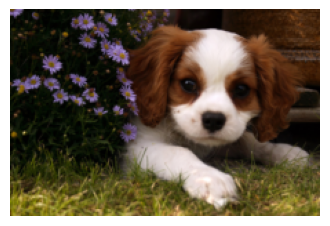

In [8]:
show_img(img)

To work with 2d data, we'll build 2d offsets and masks. Here's an illustration how it works, e.g. for an `4x7` matrix and block sizes of `2` for each dimensions.

<img src='images/4_offset_2d.png'>

And in code, it looks like this:

In [9]:
@triton.jit
def rgb2grey_k(x_ptr, out_ptr, h, w, bs0: tl.constexpr, bs1: tl.constexpr):
    pid_0 = tl.program_id(0)
    pid_1 = tl.program_id(1)
    
    offs_0 = pid_0 * bs0 + tl.arange(0,bs0)  # 1d vector
    offs_1 = pid_1 * bs1 + tl.arange(0,bs1)  # 1d vector

    # Weirdness: None-slicing currently doesn't work when simulating on cpu. Use tl.expand_dim instead.
    # offs = w * tl.expand_dims(offs_0, 1) + tl.expand_dims(offs_1, 0)
    offs = w * offs_0[:,None] + offs_1[None, :]  # 2d matrix! - we multiply first offset by width, see image above

    mask_0 = offs_0 < h  # 1d vector
    mask_1 = offs_1 < w  # 1d vector

    # mask = tl.expand_dims(mask_0, 1) & tl.expand_dims(mask_1, 0)
    mask = mask_0[:,None] & mask_1[None,:]  # 2d matrix! - data musn't go out of bounds along either axis, therefore `logical and` of the individual masks
    
    r = tl.load(x_ptr + 0*h*w+offs, mask=mask)
    g = tl.load(x_ptr + 1*h*w+offs, mask=mask)
    b = tl.load(x_ptr + 2*h*w+offs, mask=mask)

    # Weirdness: multiplying float with uint vectors fails when simulating on cpu
    out = 0.2989*r + 0.5870*g + 0.1140*b  # don't worry why it's these 3 numbers we're multiplying with

    tl.store(out_ptr + offs, out, mask=mask)

Let's use the kernel!

In [10]:
def rgb2grey(x, bs):
    c,h,w = x.shape
    out = torch.empty((h,w), dtype=x.dtype, device=x.device)

    # grid can be a function returning a 1d/2d/3d-tuple
    # (having a grid function is not more useful than a grid tuple in this case, but will be below when benchmarking & auto-tuning)
    grid = lambda meta: (cdiv(h, meta['bs0']), cdiv(w,  meta['bs1']))
    
    rgb2grey_k[grid](x, out, h, w, bs0=bs[0], bs1=bs[1]) # all kwargs are passed into grid function
    return out.view(h,w)

In [11]:
grey_img = rgb2grey(img.to('cuda'), bs=(32, 32)).to('cpu')

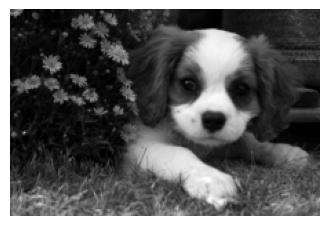

In [12]:
show_img(grey_img, cmap='gray')

Very cool

# Example 3: Matmul

_For simplicity, restart kernel here_

In [1]:
import os
# os.environ['TRITON_INTERPRET'] = '1'

import torch
import triton
import triton.language as tl

# moved util functions into separate file for better readability
from triton_util import cdiv, breakpoint_if, print_if, check_tensors_gpu_ready

Now, let's implement a naive matmul in Triton. We'll learn:
- A method to split computation 
- Calling functions from our kernel 
- Using pre-implemented vector/matrix ops within an block

This is adapted from the [OpenAI blog post announcing Triton](https://openai.com/research/triton).

We want to multiply the `m x k`-matrix `A` and the `k x n`-matrix `B` into the `m x n`-matrix `C`.

We split the computation along each of the three axes:
- along the m axis - we'll use block dimension 0 to represent this
- along the n axis - we'll use block dimension 1 to represent this
- along the shared k axis - this will not be represented by a block. All chunks of computation will be done in same block.

<img src='images/5_matmul_split.png'>

Because we frequently create 1d- or 2d-offets and -masks, let's put that functionality into utility functions. As long as these functions are `triton.jit`-ed, they can be used in the kernel.

In [2]:
@triton.jit
def get_1d_offset(size, n_prev_chunks):
    return n_prev_chunks * size + tl.arange(0, size)

@triton.jit
def get_2d_offset(offs_0, offs_1, stride_0, stride_1=1): 
    return tl.expand_dims(offs_0, 1)*stride_0 + tl.expand_dims(offs_1, 0)*stride_1

@triton.jit
def get_1d_mask(offs, max):
    return offs < max

@triton.jit
def get_2d_mask(offs_0, offs_1, max_0, max_1):
    return (tl.expand_dims(offs_0, 1) < max_0) & (tl.expand_dims(offs_1, 0) < max_1)

Here's the naive matmul kernel:

In [3]:
@triton.jit
def naive_matmul_k(
    a_ptr, b_ptr, c_ptr,
    m, n, k,
    stride_am, stride_ak, 
    stride_bk, stride_bn,
    stride_cm, stride_cn,
    bm: tl.constexpr, bn: tl.constexpr, bk: tl.constexpr
):
    pid_m, pid_n = tl.program_id(0), tl.program_id(1)
    # chunks along m/n/k dimensions
    rm = get_1d_offset(size=bm, n_prev_chunks=pid_m)
    rn = get_1d_offset(size=bn, n_prev_chunks=pid_n)
    rk = get_1d_offset(size=bk, n_prev_chunks=0)
    # relevant offsets of a, b
    offs_a = a_ptr + get_2d_offset(rm, rk, stride_am, stride_ak)
    offs_b = b_ptr + get_2d_offset(rk, rn, stride_bk, stride_bn)
    # initialize and iteratively update accumulator
    acc = tl.zeros((bm, bn), dtype=tl.float32)
    for _ in range(0, k, bk):
        # todo umer: don't we need mask when loading a & b?
        a = tl.load(offs_a)
        b = tl.load(offs_b)
        acc += tl.dot(a, b, allow_tf32=False) # matmul in block ; Weirdness: allow_tf32 must be set to False for older GPUs, otherwise won't compile
        # increase offets, so next iteration loads next chunks
        offs_a += bk * stride_ak
        offs_b += bk * stride_bk
    c = c_ptr + get_2d_offset(rm, rn, stride_cm, stride_cn)
    mask = get_2d_mask(rm, rn, m, n)
    tl.store(c, acc, mask=mask)

In [4]:
from functools import partial

def matmul(a, b, matmul_k_fn, bs=16, group_sz=None):
    assert a.shape[1] == b.shape[0], "matrix dims not compatible for matmul"
    check_tensors_gpu_ready(a, b)
    (m, k), (_, n) = a.shape, b.shape
    c = torch.empty((m, n), device=a.device, dtype=torch.float16)
    grid = lambda meta: (triton.cdiv(m, meta['bm']),  triton.cdiv(n, meta['bn']))
    group_sz = {} if group_sz is None else {"group_sz":group_sz} # not used in naive_matmul, but will be in grouped_matmul further below 
    matmul_k_fn[grid](
        a, b, c,
        m, n, k,
        a.stride(0), a.stride(1),
        b.stride(0), b.stride(1),
        c.stride(0), c.stride(1),
        bm=bs, bn=bs, bk=bs, # Weirdness: allow_tf32 must be set to False for older GPUs, otherwise won't compile
        **group_sz
    )
    return c

naive_matmul = partial(matmul, matmul_k_fn=naive_matmul_k)

In [5]:
a = torch.ones((3, 4), dtype=torch.float32, device='cuda')
b = torch.ones((4, 5), dtype=torch.float32, device='cuda')

In [6]:
naive_matmul(a,b)

tensor([[4., 4., 4., 4., 4.],
        [4., 4., 4., 4., 4.],
        [4., 4., 4., 4., 4.]], device='cuda:0', dtype=torch.float16)

Let's unit test this against PyTorch's implementation

In [7]:
torch.manual_seed(0)
a = torch.randn((512, 512), device='cuda', dtype=torch.float16)
b = torch.randn((512, 512), device='cuda', dtype=torch.float16)
triton_output = naive_matmul(a, b)
torch_output = torch.matmul(a, b)
if torch.allclose(triton_output, torch_output, atol=5e-2, rtol=0):
    print("✅ Triton and Torch match")
else:
    print("❌ Triton and Torch differ")

✅ Triton and Torch match


# Example 4: Faster Matmul

_Note: Needs code from example 3, so run that before_

Triton handles the order of memory access **within** blocks, but not **across** blocks. So this is a knob we can use to make our kernels faster.

In fact, cleverly reordering blocks can increase L2-cache hit rate, which makes our kernels faster. This example is taken from the [triton docs](https://triton-lang.org/main/getting-started/tutorials/03-matrix-multiplication.html).

Now, to make better use of the L2 cache, we want to reuse data that's was recently loaded, and is therefore likely still in the L2 cache. How? By reducing the number of _different_ data loads that a bunch of "consecutive" kernels need. By "consecutive" we mean kernels that are executed approximately at the same time.

This picture (adapter from the [triton docs](https://triton-lang.org/main/getting-started/tutorials/03-matrix-multiplication.html)) shows how we can do that. If we order naively, the first row of the output matrix is computed "consecutively", which needs 90 different block reads (9 from matrix A, 81 from matrix B). If we use "group ordering", a 3x3 square of blocks of the output matrix is computed "consecutively", which needs 54 different block reads (27 from matrix A, 27 from matrix B).

<img src='images/6_matmul_order.png'>

_Note: In the docs, grouping is called "super-grouping"_

Okay, how can we tell Triton in which order to process blocks? The answer is: We take the pids, change them, and use them as if they were the original pids.

Let's do a minimal example to illustrate this principle:

In [8]:
def process_item(id): print(f"I'm processing item {id}")

for i in range(5): process_item(i)

I'm processing item 0
I'm processing item 1
I'm processing item 2
I'm processing item 3
I'm processing item 4


In [9]:
def change_id(old_id): return 5-old_id

for i in range(5): process_item(change_id(i))

I'm processing item 5
I'm processing item 4
I'm processing item 3
I'm processing item 2
I'm processing item 1


Et voilà, the items were processed in a different order.

So how should the pid-change-function for faster matmul look like? It should change the left matrix into the right matrix.

<img src='images/7_swizzling_exmple.png'>

On the left, the default ordering is shown (called "row-major"). Remember, we deal with blocks. We can't arrange how the individual cells are processed, only the blocks. In the picture, our output matrix C has `5x7 = 35` cells, but only `cdiv(5,1) x cdiv(7,2) = 5x4 = 20` blocks.

On the right, notice how the first 9 processed blocks are the `3x3` grid we want! We process 3 blocks in a column. Then advance a column, again process 3, advance, and so on. The orange lines show where advance. This operation is called **"swizzling"**.

By the way, you can of course change the number 3. It's called the `group_size`.

You don't need to write swizzling yourself, as  there is a `triton.language.swizzle2d` function.

To really understand `swizzle2d`, let's quickly verifiy it works as expected. We'll then continue to use it in our faster matmul kernel.

_Side-Goal:_ Use `swizzle2d` on a `5x4` matrix with elements `0 ... 19` in row-major ordering. We should then get a matrix with elements in grouped ordering.

In [10]:
@triton.jit
def swizzle_k(x_ptr, z_ptr, group_sz: tl.constexpr):
    pid_m, pid_n = tl.program_id(0), tl.program_id(1)
    num_pid_m, num_pid_n = tl.num_programs(0), tl.num_programs(1)

    pid_m_, pid_n_ = tl.swizzle2d(pid_m, pid_n, num_pid_m, num_pid_n, group_sz)  # Weirdness: tl.swizzle2d doesn't work when simulating on CPU
    
    offs_m = get_1d_offset(1, n_prev_chunks=pid_m)
    offs_n = get_1d_offset(1, n_prev_chunks=pid_n)
    
    offs = get_2d_offset(offs_m, offs_n, stride_0=num_pid_n)
    mask = get_2d_mask(offs_m, offs_n, max_0=num_pid_m, max_1=num_pid_n )

    offs_sw_m = get_1d_offset(1, n_prev_chunks=pid_m_)
    offs_sw_n = get_1d_offset(1, n_prev_chunks=pid_n_)
    
    offs_sw = get_2d_offset(offs_sw_m, offs_sw_n, stride_0=num_pid_n)
    mask_sw = get_2d_mask(offs_sw_m, offs_sw_n, max_0=num_pid_m, max_1=num_pid_n)
    
    x = tl.load(x_ptr + offs, mask=mask)
    tl.store(z_ptr + offs_sw, x, mask=mask_sw)

In [11]:
blocks_m, blocks_n = 5,4

x = torch.arange(blocks_m*blocks_n, device='cuda').view(blocks_m,blocks_n)
x

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15],
        [16, 17, 18, 19]], device='cuda:0')

In [12]:
z = -torch.ones_like(x) # empty matrix, with -1 denoting empty
z

tensor([[-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1]], device='cuda:0')

In [13]:
# swizzle x into z
swizzle_k[(blocks_m,blocks_n)](x,z, group_sz=3);

In [14]:
z

tensor([[ 0,  3,  6,  9],
        [ 1,  4,  7, 10],
        [ 2,  5,  8, 11],
        [12, 14, 16, 18],
        [13, 15, 17, 19]], device='cuda:0')

Looks good!

___

Let's now implement the grouped matmul kernel, which will be faster than the regular matmul.

In [15]:
@triton.jit
def grouped_matmul_k(
    a_ptr, b_ptr, c_ptr,
    m, n, k,
    stride_am, stride_ak, 
    stride_bk, stride_bn,
    stride_cm, stride_cn,
    bm: tl.constexpr, bn: tl.constexpr, bk: tl.constexpr, group_sz: tl.constexpr
):
    pid_m, pid_n = tl.program_id(0), tl.program_id(1)
    num_pid_m, num_pid_n = tl.num_programs(0), tl.num_programs(1)
    # determine location of block in grouped ordering - swizzle! 
    pid_m, pid_n = tl.swizzle2d(pid_m, pid_n, num_pid_m, num_pid_n, group_sz)  # Weirdness: tl.swizzle2d doesn't work when simulating on CPU
    # chunks along m/n/k dimensions
    rm = get_1d_offset(size=bm, n_prev_chunks=pid_m)
    rn = get_1d_offset(size=bn, n_prev_chunks=pid_n)
    rk = get_1d_offset(size=bk, n_prev_chunks=0)
    # relevant offsets of a, b
    offs_a = a_ptr + get_2d_offset(rm, rk, stride_am, stride_ak)
    offs_b = b_ptr + get_2d_offset(rk, rn, stride_bk, stride_bn)
    # initialize and iteratively update accumulator
    acc = tl.zeros((bm, bn), dtype=tl.float32)
    for _ in range(0, k, bk):
        # todo umer: don't we need mask when loading a & b?
        a = tl.load(offs_a)
        b = tl.load(offs_b)
        acc += tl.dot(a, b, allow_tf32=False) # block level matrix multiplication ; Weirdness: allow_tf32 must be set to False for older GPUs, otherwise won't compile
        # increase offets, so next iteration loads next chunks
        offs_a += bk * stride_ak
        offs_b += bk * stride_bk
    c = c_ptr + get_2d_offset(rm, rn, stride_cm, stride_cn)
    mask = get_2d_mask(rm, rn, m, n)
    tl.store(c, acc, mask=mask)

In [16]:
grouped_matmul = partial(matmul, matmul_k_fn=grouped_matmul_k)

In [17]:
a = torch.ones((3, 4), dtype=torch.float32, device='cuda')
b = torch.ones((4, 5), dtype=torch.float32, device='cuda')

In [18]:
grouped_matmul(a,b, group_sz=4)

tensor([[4., 4., 4., 4., 4.],
        [4., 4., 4., 4., 4.],
        [4., 4., 4., 4., 4.]], device='cuda:0', dtype=torch.float16)

Let's unit test this against PyTorch's implementation

In [19]:
torch.manual_seed(0)
a = torch.randn((512, 512), device='cuda', dtype=torch.float16)
b = torch.randn((512, 512), device='cuda', dtype=torch.float16)
triton_output = grouped_matmul(a, b, group_sz=32)
torch_output = torch.matmul(a, b)
if torch.allclose(triton_output, torch_output, atol=5e-2, rtol=0):
    print("✅ Triton and Torch match")
else:
    print("❌ Triton and Torch differ")

✅ Triton and Torch match


# Benchmarking

Triton brings built-in benchmarking tools with it. Here's an example how to use it.

In [20]:
# adapted from https://triton-lang.org/main/getting-started/tutorials/01-vector-add.html
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['square_matrix_size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(5, 12, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['naive', 'grouped', 'torch'],  # Possible values for `line_arg`.
        line_names=['Naive', 'Grouped', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-'), ('orange','-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='matmul-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(square_matrix_size, provider):
    sz = square_matrix_size
    a = torch.rand((sz, sz), device='cuda', dtype=torch.float32)
    b = torch.rand((sz, sz), device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'naive':   ms, min_ms, max_ms = triton.testing.do_bench(lambda: naive_matmul(a, b), quantiles=quantiles)
    if provider == 'grouped': ms, min_ms, max_ms = triton.testing.do_bench(lambda: grouped_matmul(a, b, group_sz=8), quantiles=quantiles)
    if provider == 'torch':   ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a,b), quantiles=quantiles)
    gbps = lambda ms: 12 * sz / ms * 1e-6
    return gbps(ms), gbps(max_ms), gbps(min_ms)

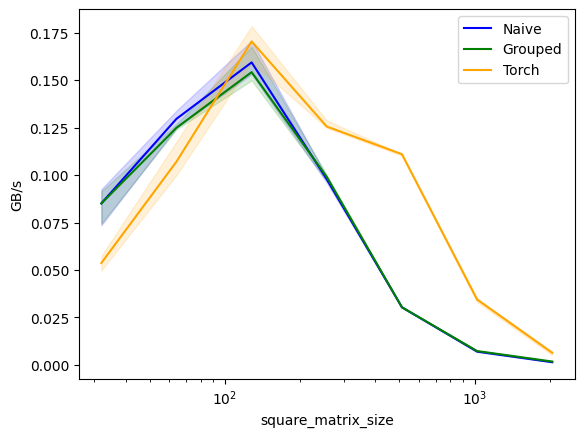

matmul-performance:
   square_matrix_size     Naive   Grouped     Torch
0                32.0  0.085106  0.085106  0.053691
1                64.0  0.129730  0.125000  0.107143
2               128.0  0.159468  0.154341  0.170515
3               256.0  0.097909  0.099071  0.125654
4               512.0  0.030346  0.030361  0.111079
5              1024.0  0.006971  0.007279  0.034461
6              2048.0  0.001405  0.001749  0.006355


In [21]:
benchmark.run(print_data=True, show_plots=True)

_Note Umer: I would've expected the GB/s to increase as the matrix sizes get larger. Why don't they? Maybe because share memory is full, so kernel spends more and more time reloading stuff_

Let's try different block sizes:

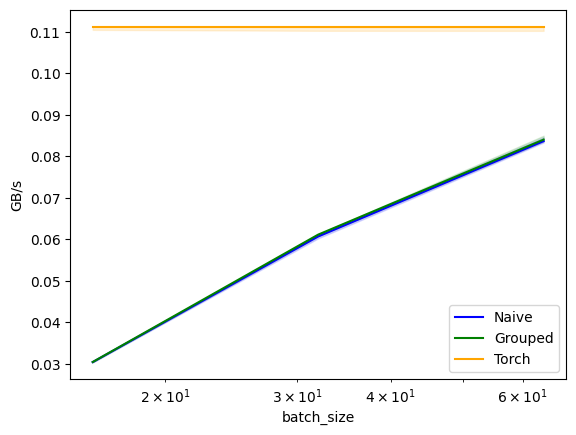

matmul-performance:
   batch_size     Naive   Grouped     Torch
0        16.0  0.030404  0.030433  0.111111
1        32.0  0.060683  0.061127  0.111111
2        64.0  0.083660  0.084026  0.111111


In [22]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['batch_size'], x_vals=[2**i for i in range(4, 7, 1)], x_log=True,
        line_arg='provider', line_vals=['naive', 'grouped', 'torch'], line_names=['Naive', 'Grouped', 'Torch'],
        styles=[('blue', '-'), ('green', '-'), ('orange','-')],
        ylabel='GB/s', plot_name='matmul-performance', args={}
    ))
def benchmark(batch_size, provider):
    sz = 512
    a = torch.rand((sz, sz), device='cuda', dtype=torch.float32)
    b = torch.rand((sz, sz), device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'naive':   ms, min_ms, max_ms = triton.testing.do_bench(lambda: naive_matmul(a, b, bs=batch_size), quantiles=quantiles)
    if provider == 'grouped': ms, min_ms, max_ms = triton.testing.do_bench(lambda: grouped_matmul(a, b, bs=batch_size, group_sz=8), quantiles=quantiles)
    if provider == 'torch':   ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a,b), quantiles=quantiles)
    gbps = lambda ms: 12 * sz / ms * 1e-6
    return gbps(ms), gbps(max_ms), gbps(min_ms)

benchmark.run(print_data=True, show_plots=True)

Larger block sizes seem to be better. Let's compare with pytorch again, using larger block sizes.

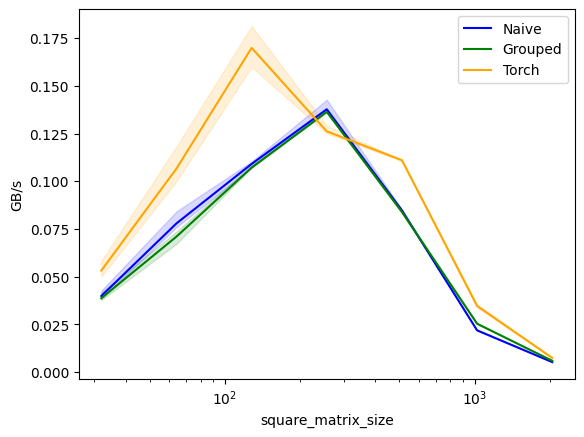

matmul-performance:
   square_matrix_size     Naive   Grouped     Torch
0                32.0  0.039867  0.038710  0.053215
1                64.0  0.077922  0.071006  0.106667
2               128.0  0.109091  0.107143  0.169912
3               256.0  0.137733  0.136364  0.126150
4               512.0  0.084731  0.083916  0.111047
5              1024.0  0.021879  0.025362  0.034691
6              2048.0  0.005257  0.005919  0.007440


In [23]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['square_matrix_size'], x_vals=[2**i for i in range(5, 12, 1)], x_log=True,
        line_arg='provider', line_vals=['naive', 'grouped', 'torch'], line_names=['Naive', 'Grouped', 'Torch'],
        styles=[('blue', '-'), ('green', '-'), ('orange','-')],
        ylabel='GB/s', plot_name='matmul-performance', args={}
    ))
def benchmark(square_matrix_size, provider):
    sz = square_matrix_size
    a = torch.rand((sz, sz), device='cuda', dtype=torch.float32)
    b = torch.rand((sz, sz), device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'naive':   ms, min_ms, max_ms = triton.testing.do_bench(lambda: naive_matmul(a, b, bs=64), quantiles=quantiles)
    if provider == 'grouped': ms, min_ms, max_ms = triton.testing.do_bench(lambda: grouped_matmul(a, b, group_sz=8, bs=64), quantiles=quantiles)
    if provider == 'torch':   ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a,b), quantiles=quantiles)
    gbps = lambda ms: 12 * sz / ms * 1e-6
    return gbps(ms), gbps(max_ms), gbps(min_ms)

benchmark.run(print_data=True, show_plots=True)

This reduces the performance difference to pytorch for larger matrix sizes, but pytorch is still better.

Tip: For profiling, we can use Nsight Compute to profile our kernels:
`ncu --target-processes all your_python_file.py`

# Auto-Tuning

Adapted from https://triton-lang.org/main/getting-started/tutorials/03-matrix-multiplication.html

The choice of meta-parameters (e.g. block sizes) and compilation options (e.g. `num_warps`) impacts the kernel speed. Triton allows you to pass a list of possible choices, runs them all, and then compiles the kernel for the fastest choice. This is called `Auto-Tuning`.

If the size of your problem changes (e.g. when matrix changes size), a new auto-tune will be done for the new problem size.

In [24]:
@triton.autotune(
    # Choices of configs to auto-tune over
    configs=[
        triton.Config({'bm': 128, 'bn': 256, 'bk': 64, 'group_sz': 8}, num_stages=3, num_warps=8),
        triton.Config({'bm': 64, 'bn': 256, 'bk': 32, 'group_sz': 8}, num_stages=4, num_warps=4),
        triton.Config({'bm': 128, 'bn': 128, 'bk': 32, 'group_sz': 8}, num_stages=4, num_warps=4),
        triton.Config({'bm': 128, 'bn': 64, 'bk': 32, 'group_sz': 8}, num_stages=4, num_warps=4),
        triton.Config({'bm': 64, 'bn': 128, 'bk': 32, 'group_sz': 8}, num_stages=4, num_warps=4),
        triton.Config({'bm': 128, 'bn': 32, 'bk': 32, 'group_sz': 8}, num_stages=4, num_warps=4),
        triton.Config({'bm': 64, 'bn': 32, 'bk': 32, 'group_sz': 8}, num_stages=5, num_warps=2),
        triton.Config({'bm': 32, 'bn': 64, 'bk': 32, 'group_sz': 8}, num_stages=5, num_warps=2),
    ],
    # Definition of problem size. If it changes, a new auto-tune is run for the new problem size.
    key=['m', 'n', 'k'],
)
@triton.jit
def grouped_autotuned_matmul_k(
    a_ptr, b_ptr, c_ptr,
    m, n, k,
    stride_am, stride_ak, 
    stride_bk, stride_bn,
    stride_cm, stride_cn,
    bm: tl.constexpr, bn: tl.constexpr, bk: tl.constexpr, group_sz: tl.constexpr
):
    pid_m = tl.program_id(0)
    pid_n = tl.program_id(1)
    num_pid_m = tl.num_programs(0)
    num_pid_n = tl.num_programs(1)
    # determine location of block in grouped ordering
    pid_m, pid_n = tl.swizzle2d(pid_m, pid_n, num_pid_m, num_pid_n, group_sz)  # Weirdness: tl.swizzle2d doesn't work when simulating on CPU
    # chunks along m/n/k dimensions
    rm = get_1d_offset(size=bm, n_prev_chunks=pid_m)
    rn = get_1d_offset(size=bn, n_prev_chunks=pid_n)
    rk = get_1d_offset(size=bk, n_prev_chunks=0)
    # relevant offsets of a, b
    offs_a = a_ptr + get_2d_offset(rm, rk, stride_am, stride_ak)
    offs_b = b_ptr + get_2d_offset(rk, rn, stride_bk, stride_bn)
    # initialize and iteratively update accumulator
    acc = tl.zeros((bm, bn), dtype=tl.float32)
    for _ in range(0, k, bk):
        # todo umer: don't we need mask when loading a & b?
        a = tl.load(offs_a)
        b = tl.load(offs_b)
        acc += tl.dot(a, b, allow_tf32=False) # block level matrix multiplication ; Weirdness: allow_tf32 must be set to False for older GPUs, otherwise won't compile
        # increase offets, so next iteration loads next chunks
        offs_a += bk * stride_ak
        offs_b += bk * stride_bk
    c = c_ptr + get_2d_offset(rm, rn, stride_cm, stride_cn)
    mask = get_2d_mask(rm, rn, m, n)
    tl.store(c, acc, mask=mask)

In [25]:
def grouped_autotuned_matmul(a, b):
    matmul_k_fn = grouped_autotuned_matmul_k
    
    assert a.shape[1] == b.shape[0], "matrix dims not compatible for matmul"
    check_tensors_gpu_ready(a, b)
    (m, k), (_, n) = a.shape, b.shape
    c = torch.empty((m, n), device=a.device, dtype=torch.float16)
    grid = lambda meta: (triton.cdiv(m, meta['bm']),  triton.cdiv(n, meta['bn']))
    matmul_k_fn[grid](
        a, b, c,
        m, n, k,
        a.stride(0), a.stride(1),
        b.stride(0), b.stride(1),
        c.stride(0), c.stride(1),
        # bm=bs, bn=bs, bk=bs, <- will be autotuned
        # **group_sz <- will be autotuned
    )
    return c

In [26]:
a,b = torch.ones(3,4, device='cuda'), torch.ones(4,5, device='cuda')

In [27]:
a@b

tensor([[4., 4., 4., 4., 4.],
        [4., 4., 4., 4., 4.],
        [4., 4., 4., 4., 4.]], device='cuda:0')

_Note: sometimes the following line returns wrong results, and I can't reliably reproduce it. If you can, please tell me via Twitter (@UmerHAdil) ! 🙏🏽_

In [28]:
grouped_autotuned_matmul(a,b)

tensor([[4., 4., 4., 4., 4.],
        [4., 4., 4., 4., 4.],
        [4., 4., 4., 4., 4.]], device='cuda:0', dtype=torch.float16)

For tips, tricks and heuristics which configs to try for auto-tuning, see [Mark Saroufim's talk "CUDA Performance Checklist"](https://www.youtube.com/watch?v=SGhfUhlowB4). Much of it should apply to Triton as well.

Let's run the benchmark once again. This will take a lot of time, as we auto-tune for each benchmarking paramater choice (i.e., 12-5=7 times for us).

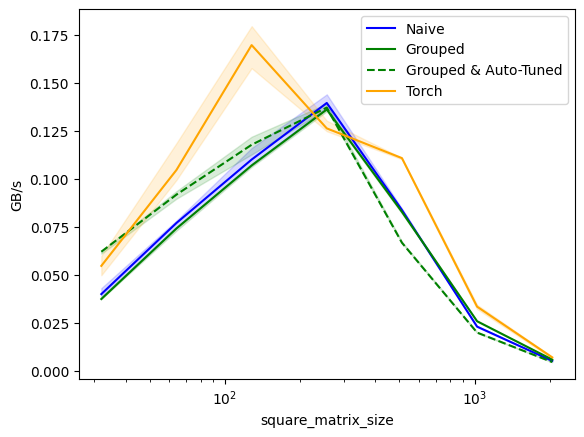

matmul-performance:
   square_matrix_size     Naive   Grouped  Grouped & Auto-Tuned     Torch
0                32.0  0.040067  0.037500              0.062176  0.054795
1                64.0  0.077170  0.074303              0.091954  0.104803
2               128.0  0.110218  0.107143              0.117936  0.169912
3               256.0  0.139738  0.136364              0.137339  0.126482
4               512.0  0.083953  0.082937              0.066864  0.110983
5              1024.0  0.023112  0.025932              0.020007  0.033520
6              2048.0  0.005235  0.005912              0.004629  0.007076


In [30]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['square_matrix_size'], x_vals=[2**i for i in range(5, 12, 1)], x_log=True,
        line_arg='provider', line_vals=['naive', 'grouped', 'grouped-autotuned', 'torch'], line_names=['Naive', 'Grouped', 'Grouped & Auto-Tuned','Torch'],
        styles=[('blue', '-'), ('green', '-'), ('green', '--'), ('orange','-')],
        ylabel='GB/s', plot_name='matmul-performance', args={}
    ))
def benchmark(square_matrix_size, provider):
    sz = square_matrix_size
    a = torch.rand((sz, sz), device='cuda', dtype=torch.float32)
    b = torch.rand((sz, sz), device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'naive':   ms, min_ms, max_ms = triton.testing.do_bench(lambda: naive_matmul(a, b, bs=64), quantiles=quantiles)
    if provider == 'grouped': ms, min_ms, max_ms = triton.testing.do_bench(lambda: grouped_matmul(a, b, group_sz=8, bs=64), quantiles=quantiles)
    if provider == 'grouped-autotuned': ms, min_ms, max_ms = triton.testing.do_bench(lambda: grouped_autotuned_matmul(a, b), quantiles=quantiles)
    if provider == 'torch':   ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a,b), quantiles=quantiles)
    gbps = lambda ms: 12 * sz / ms * 1e-6
    return gbps(ms), gbps(max_ms), gbps(min_ms)

benchmark.run(print_data=True, show_plots=True)

___

<h1>That's it! Congrats on making it through the tutorial - good work! 🥳</h1>

I highly encourage you to write a few triton kernels yourself. You can e.g. try these triton puzzles: https://github.com/srush/Triton-Puzzles by [Sasha Rush](https://twitter.com/srush_nlp), Tejas Ramesh and [Keren Zhou](https://twitter.com/ZhouKeren).

Here is other intermediate and advanced material:
- The official documentation: https://triton-lang.org/
- The LightLLM repo has a ton of real-world triton kernels: https://github.com/ModelTC/lightllm/tree/main/lightllm/common/basemodel/triton_kernel
- So does the Unsloth repo: https://github.com/unslothai/unsloth/tree/main/unsloth/kernels

If you're generally interested in GPU programming and performance, the [cuda mode Discord](https://discord.gg/cudamode) may be interesting to you. This tutorial was written as part of their amazing [lecture series](https://www.youtube.com/@CUDAMODE).

___

**About the author:**

Hey 👋🏽 I'm Umer from Germany. Thanks for reading this tutorial. I hope you got learned a lot from it. If you have any questions, feel free to shoot me a message on Twitter ([@UmerHAdil](https://x.com/UmerHAdil)).

As I currently do Open-Source AI work as an independent ML engineer, I have set up a ko-fi page for tips & donations: https://ko-fi.com/umerha.
Apart from this guide, I've contributed to HuggingFace diffusers (e.g. [shoutouts by HF](https://x.com/RisingSayak/status/1773739194474463629)), LangChain [shoutouts by the team](https://twitter.com/search?lang=de&q=(from%3ALangChainAI)%20(%40UmerHAdil)%20lang%3Aen&src=typed_query)), and gpt-engineer (e.g. [this](https://x.com/UmerHAdil/status/1715447656527339668)).

If you're a company in need of Triton and/or CUDA consulting, also shoot me a message on Twitter ([@UmerHAdil](https://x.com/UmerHAdil)).